In [11]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

# Убедимся, что TensorFlow использует GPU (если доступен)
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"GPU доступен: {physical_devices}")
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    print("GPU не найден, используется CPU.")
    
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Reshape, Conv2D

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization

TensorFlow version: 2.18.0
GPU не найден, используется CPU.


In [12]:
model = tf.keras.models.load_model("SAVED_MODELS/model_19.11.24_ds3_1.keras")
BUTCH_SIZE = 1 # Butch size
IMG_SIZE = (128, 128)  # Img Size

In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def predict_image(model, image_path, image_size=(128, 128)):
    """
    Прогоняет изображение через модель для получения предсказания.
    
    Аргументы:
    - model: обученная модель.
    - image_path: путь к изображению.
    - image_size: размер, до которого изображение будет приведено (по умолчанию 128x128).
    
    Вывод:
    - Отображает оригинальное изображение, зашумленное и предсказанное изображение.
    """
    # Шаг 1: Загрузка изображения
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)  # Градации серого
    image = tf.image.resize(image, IMG_SIZE)  # Изменение размера
    image = tf.cast(image, tf.float32) / 255.0  # Нормализация в диапазон [0, 1]
    
    # Добавляем дополнительную ось для батча (нужно для модели)
    noisy_image = tf.expand_dims(image, axis=0)

    # Шаг 2: Прогоняем через модель
    predicted_image = model.predict(noisy_image)

    # Шаг 3: Отображение изображений
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle("Check predictions NW", fontsize=16)

    # Оригинальное изображение (чистое)
    axes[0].imshow(image.numpy().squeeze(), cmap='gray')
    axes[0].set_title("INPUT")
    axes[0].axis("off")

    # Зашумленное изображение
    # axes[1].imshow(noisy_image.numpy().squeeze(), cmap='gray')
    # axes[1].set_title("NW's img")
    # axes[1].axis("off")

    # Предсказанное изображение
    axes[1].imshow(predicted_image.squeeze(), cmap='gray')
    axes[1].set_title("OUTPUT")
    axes[1].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
def predict_image_with_losses(model, image_path, clean_image_path, image_size=(128, 128)):
    """
    Прогоняет изображение через модель и отображает его с предсказанием, значением функции потерь для входного и выходного изображения.
    
    Аргументы:
    - model: обученная модель.
    - image_path: путь к зашумленному изображению.
    - clean_image_path: путь к чистому изображению.
    - image_size: размер, до которого изображение будет приведено (по умолчанию 128x128).
    """
    # Загрузка и обработка зашумленного изображения
    noisy_image = tf.io.read_file(image_path)
    noisy_image = tf.image.decode_png(noisy_image, channels=1)
    noisy_image = tf.image.resize(noisy_image, image_size)
    noisy_image = tf.cast(noisy_image, tf.float32) / 255.0
    noisy_image_batch = tf.expand_dims(noisy_image, axis=0)  # Для модели

    # Загрузка и обработка чистого изображения
    clean_image = tf.io.read_file(clean_image_path)
    clean_image = tf.image.decode_png(clean_image, channels=1)
    clean_image = tf.image.resize(clean_image, image_size)
    clean_image = tf.cast(clean_image, tf.float32) / 255.0

    # Прогоняем через модель
    predicted_image = model.predict(noisy_image_batch)[0]

    # Вычисление функций потерь (MSE) для входного и выходного изображения
    mse_input = tf.keras.losses.MeanSquaredError()(clean_image, noisy_image).numpy()
    mse_output = tf.keras.losses.MeanSquaredError()(clean_image, predicted_image).numpy()
    kappa = mse_input - mse_output
    psi = mse_input / mse_output

    # Отображение изображений
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f"MSE (Input): {mse_input:.4f}, MSE (Output): {mse_output:.4f}, kappa: {kappa}, psi: {psi}", fontsize=16)

    # Входное зашумленное изображение
    axes[0].imshow(noisy_image.numpy().squeeze(), cmap='gray')
    axes[0].set_title("Noisy Input")
    axes[0].axis("off")

    # Истинное изображение
    # axes[1].imshow(clean_image.numpy().squeeze(), cmap='gray')
    # axes[1].set_title("Clean Image")
    # axes[1].axis("off")

    # Предсказанное изображение
    axes[1].imshow(predicted_image.squeeze(), cmap='gray')
    axes[1].set_title("Predicted Output")
    axes[1].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
def save_predicted_image(model, image_path, output_path, image_size=(128, 128)):
    """
    Прогоняет изображение через модель и сохраняет предсказанное изображение в формате PNG.
    
    Аргументы:
    - model: обученная модель.
    - image_path: путь к зашумленному изображению.
    - output_path: путь для сохранения предсказанного изображения.
    - image_size: размер, до которого изображение будет приведено (по умолчанию 128x128).
    """
    # Загрузка и обработка зашумленного изображения
    noisy_image = tf.io.read_file(image_path)
    noisy_image = tf.image.decode_png(noisy_image, channels=1)
    noisy_image = tf.image.resize(noisy_image, image_size)
    noisy_image = tf.cast(noisy_image, tf.float32) / 255.0
    noisy_image_batch = tf.expand_dims(noisy_image, axis=0)  # Для модели

    # Прогон через модель
    predicted_image = model.predict(noisy_image_batch)[0]

    # Преобразование в 8-битное изображение (диапазон 0-255)
    predicted_image = np.clip(predicted_image * 255, 0, 255).astype(np.uint8)

    # Сохранение изображения
    tf.keras.preprocessing.image.save_img(output_path, predicted_image, scale=False)
    print(f"Предсказанное изображение сохранено по пути: {output_path}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step


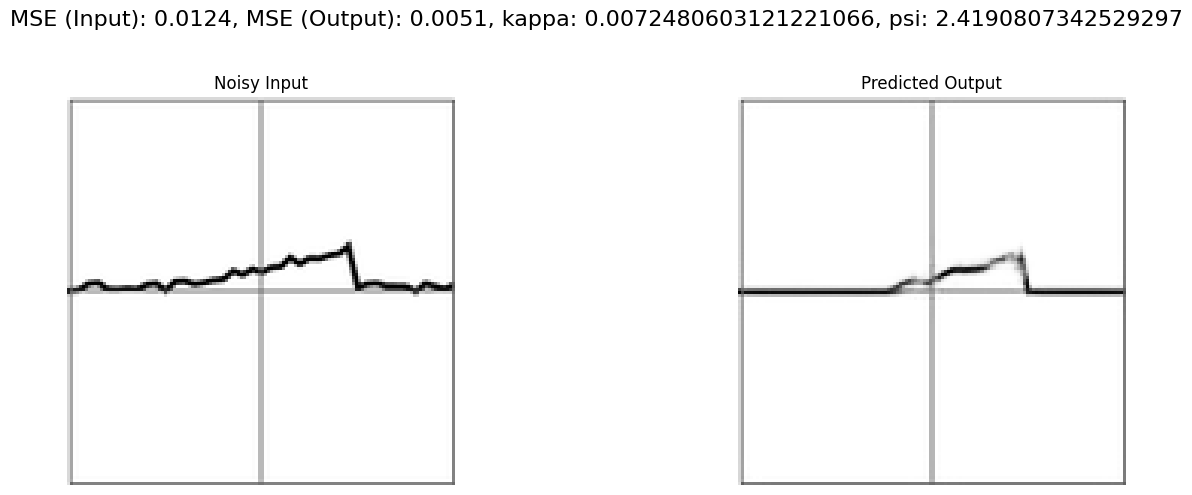

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


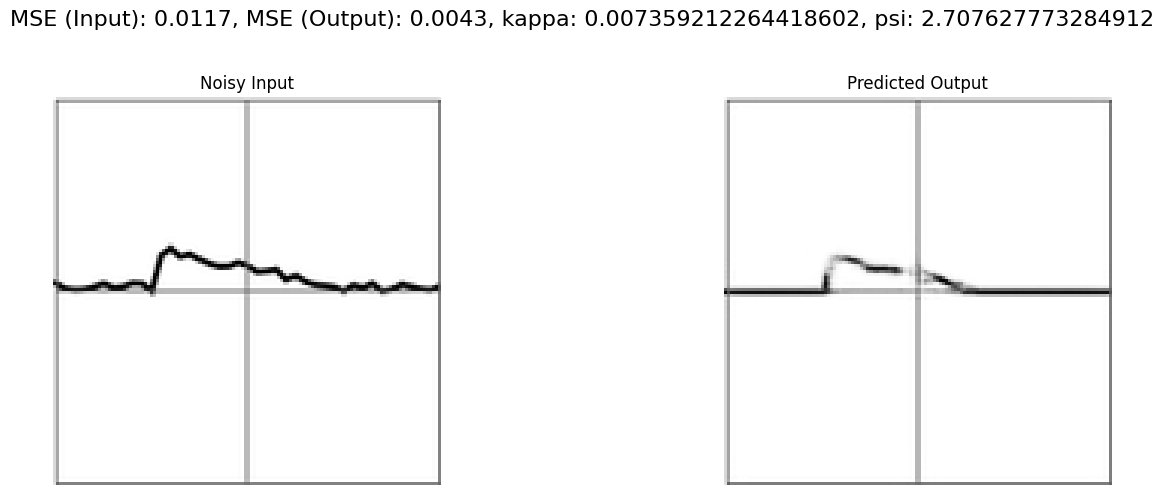

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


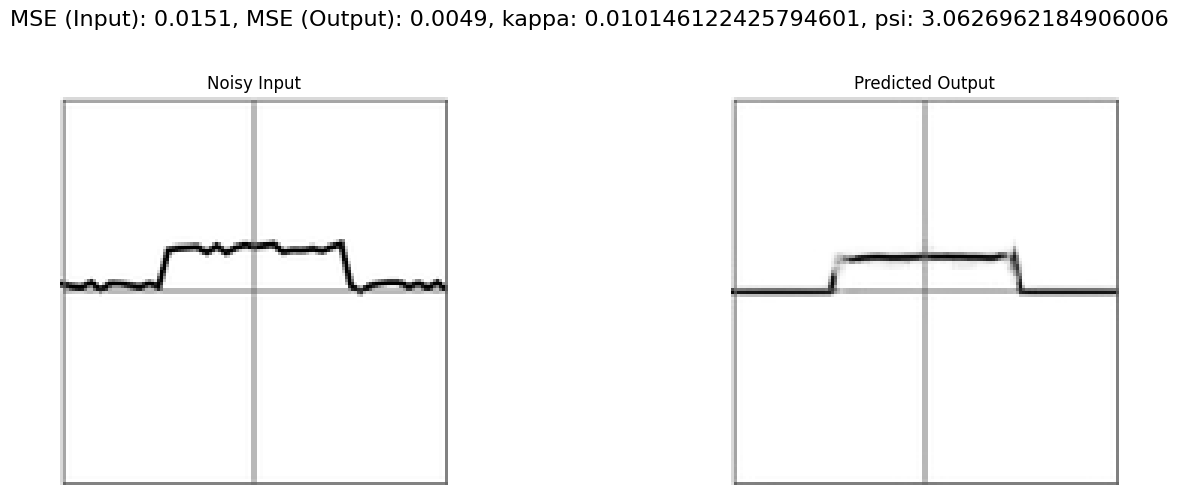

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


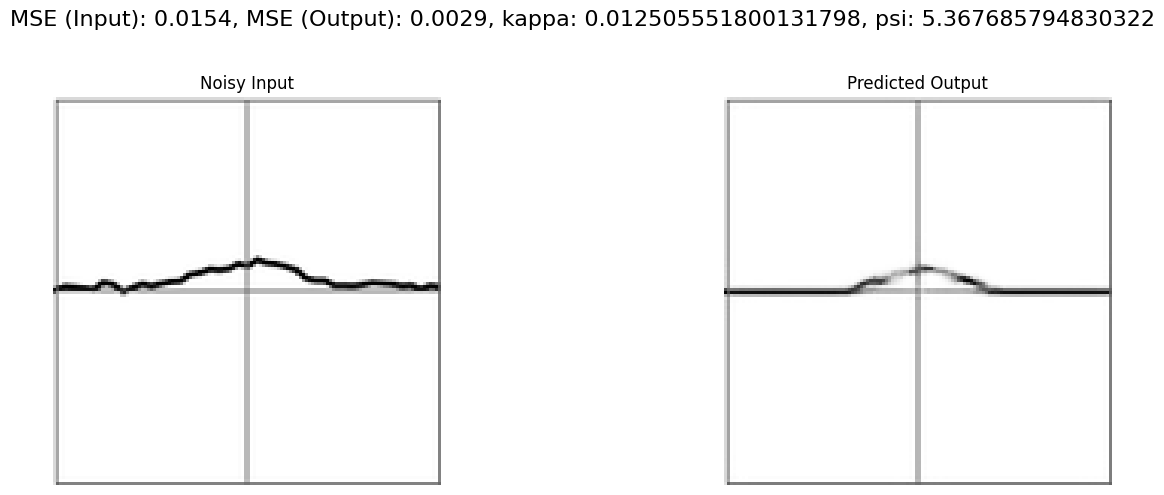

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


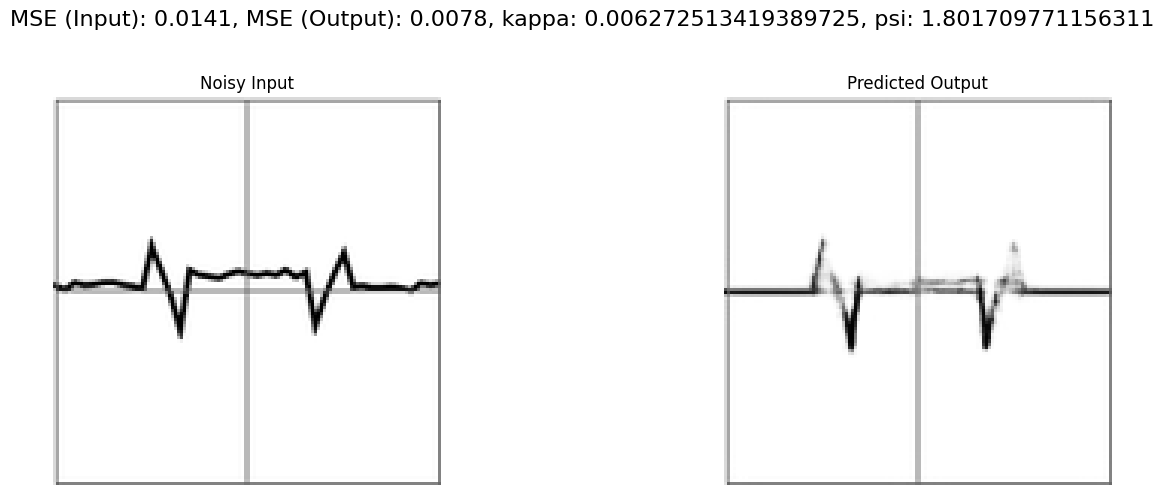

In [14]:
model = tf.keras.models.load_model("SAVED_MODELS/model_19.11.24_1.keras")

image_path = "DATASETS/DATASET_4/fig1/noize/1.png"  
clear_path = "DATASETS/DATASET_4/fig1/clear/1.png"
predict_image_with_losses(model, image_path, clear_path)

image_path = "DATASETS/DATASET_4/fig2/noize/1.png"  
clear_path = "DATASETS/DATASET_4/fig2/clear/1.png"
predict_image_with_losses(model, image_path, clear_path)

image_path = "DATASETS/DATASET_4/fig3/noize/1.png"  
clear_path = "DATASETS/DATASET_4/fig3/clear/1.png"
predict_image_with_losses(model, image_path, clear_path)

image_path = "DATASETS/DATASET_4/fig4/noize/1.png"  
clear_path = "DATASETS/DATASET_4/fig4/clear/1.png"
predict_image_with_losses(model, image_path, clear_path)

image_path = "DATASETS/DATASET_4/fig5/noize/1.png"  
clear_path = "DATASETS/DATASET_4/fig5/clear/1.png"
predict_image_with_losses(model, image_path, clear_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step


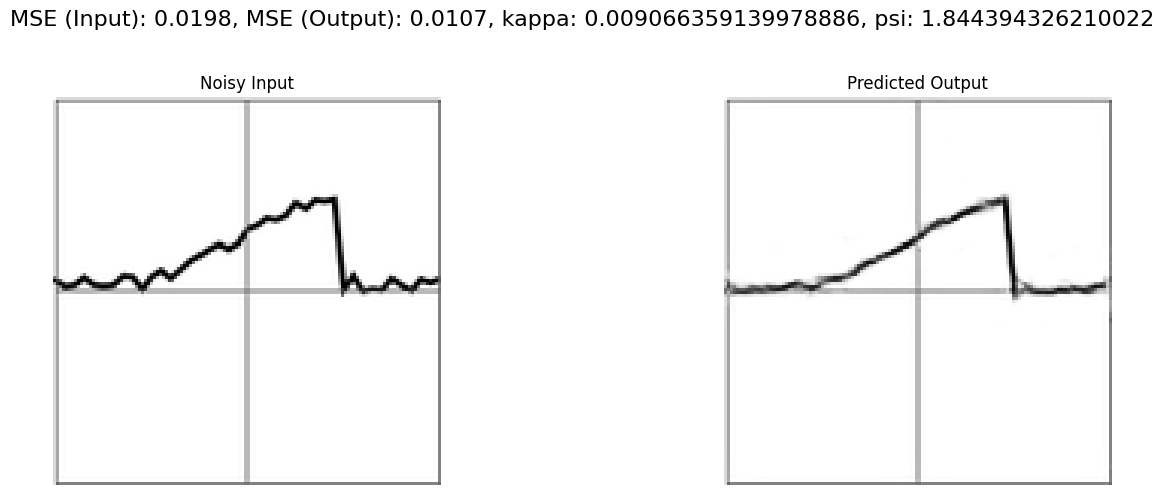

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Предсказанное изображение сохранено по пути: res_n2_2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


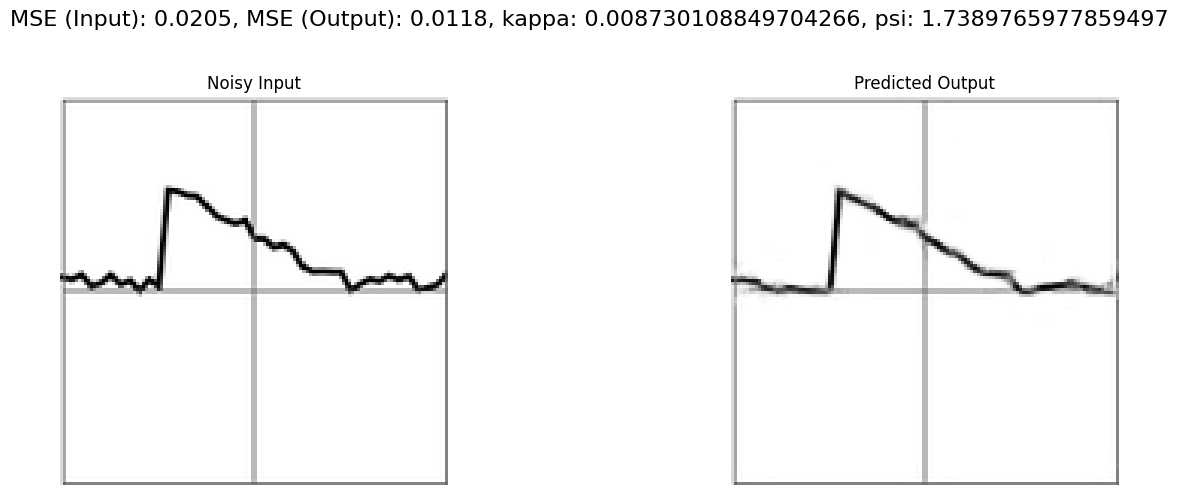

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Предсказанное изображение сохранено по пути: res_n2_4.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


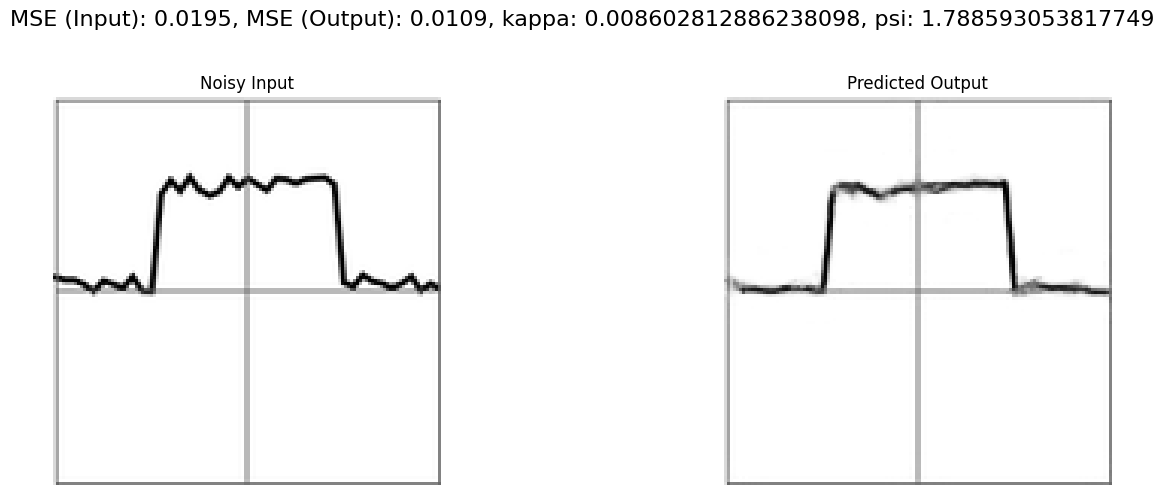

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Предсказанное изображение сохранено по пути: res_n2_6.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


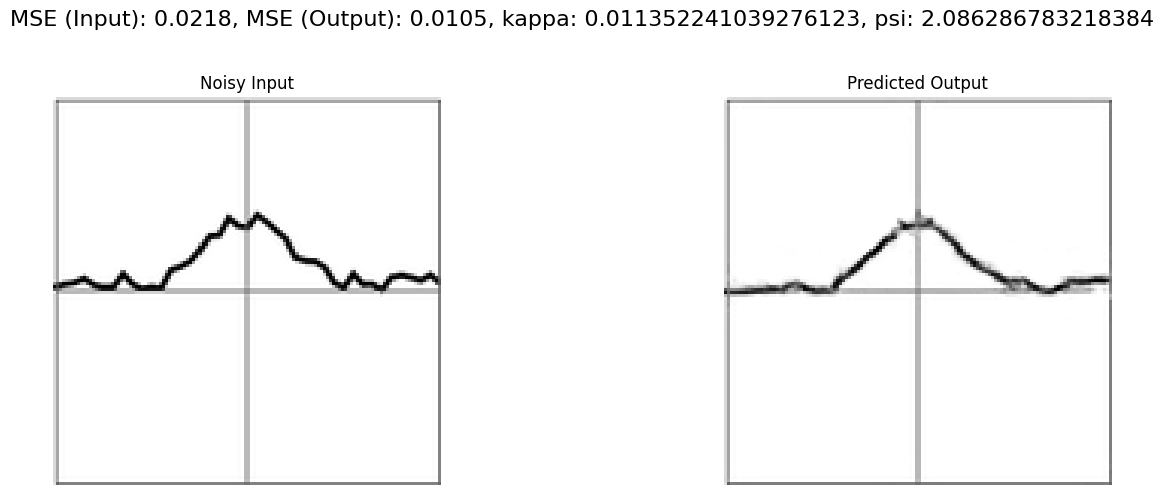

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Предсказанное изображение сохранено по пути: res_n2_8.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


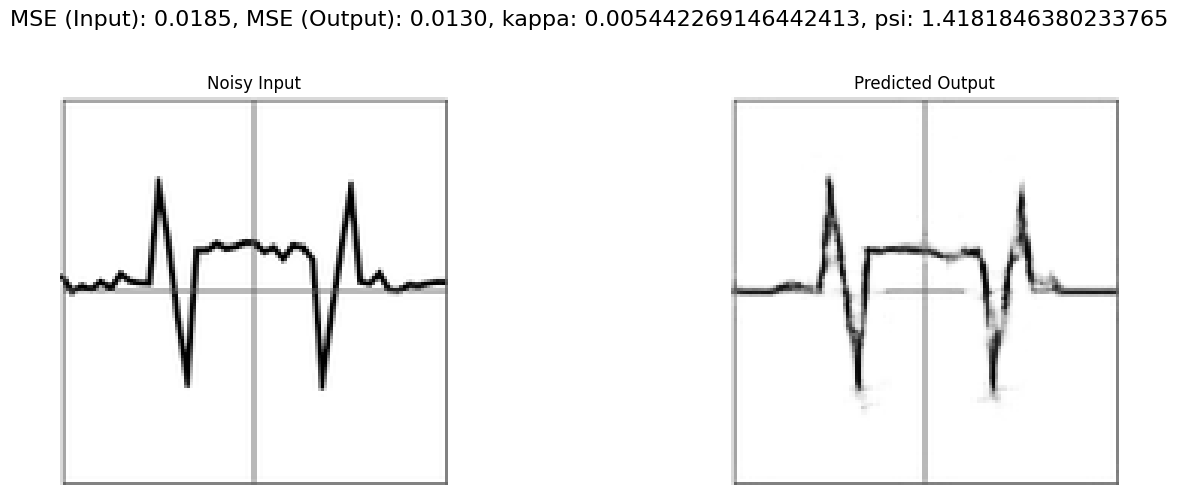

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Предсказанное изображение сохранено по пути: res_n2_10.png


In [20]:
model = tf.keras.models.load_model("SAVED_MODELS/model_19.11.24_ds3_1.keras")

image_path = "DATASETS/DATASET_2/fig1/1.png"  
clear_path = "DATASETS/DATASET_2/truefig1/1.png"
predict_image_with_losses(model, image_path, clear_path)
save_predicted_image(model, image_path, "res_n2_2.png")


image_path = "DATASETS/DATASET_2/fig2/1.png"  
clear_path = "DATASETS/DATASET_2/truefig2/2.png"
predict_image_with_losses(model, image_path, clear_path)
save_predicted_image(model, image_path, "res_n2_4.png")


image_path = "DATASETS/DATASET_2/fig3/1.png"  
clear_path = "DATASETS/DATASET_2/truefig3/3.png"
predict_image_with_losses(model, image_path, clear_path)
save_predicted_image(model, image_path, "res_n2_6.png")

image_path = "DATASETS/DATASET_2/fig4/1.png"  
clear_path = "DATASETS/DATASET_2/truefig4/4.png"
predict_image_with_losses(model, image_path, clear_path)
save_predicted_image(model, image_path, "res_n2_8.png")

image_path = "DATASETS/DATASET_2/fig5/1.png"  
clear_path = "DATASETS/DATASET_2/truefig5/5.png"
predict_image_with_losses(model, image_path, clear_path)
save_predicted_image(model, image_path, "res_n2_10.png")
#54, 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


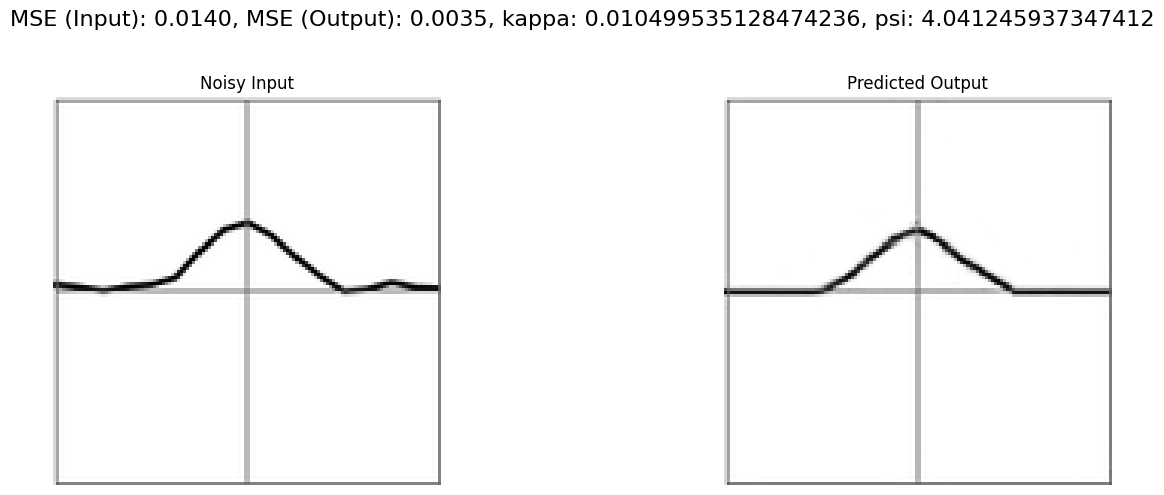

In [28]:
image_path = "DATASETS/DATASET_4/fig4/noize/25.png"  
clear_path = "DATASETS/DATASET_4/fig4/clear/25.png"
predict_image_with_losses(model, image_path, clear_path)
#save_predicted_image(model, image_path, "res_n2_8.png")